<a href="https://colab.research.google.com/github/aliakbarbadri/dogs-cats-classification/blob/master/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation
from tensorflow.keras.applications import DenseNet169
import tensorflow_datasets as tfds
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files

https://www.kaggle.com/xhlulu/densenet-transfer-learning-iwildcam-2019

https://www.tensorflow.org/tutorials/images/transfer_learning

In [0]:
(raw_train, raw_valid, raw_test), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:60%]', 'train[60%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [0]:
IMG_SIZE = 160
def resize_image(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [0]:
train = raw_train.map(resize_image)
valid = raw_valid.map(resize_image)
test = raw_test.map(resize_image)

In [0]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
valid_batches = valid.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [0]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [37]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 160, 160, 3])

In [38]:
densenet = DenseNet169(include_top=False,input_shape=IMG_SHAPE,weights='imagenet')
feature_batch = densenet(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1664)


In [0]:
densenet.trainable = False

In [40]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1664)
(32, 1)


In [0]:
model = tf.keras.Sequential([
  densenet,
  global_average_layer,
  prediction_layer
])

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 5, 5, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1664)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1665      
Total params: 12,644,545
Trainable params: 1,665
Non-trainable params: 12,642,880
_________________________________________________________________


In [44]:
history = model.fit(train_batches,epochs=10,validation_data=valid_batches)

Epoch 1/10
437/437 [==============================] - 71s 161ms/step - loss: 0.2522 - accuracy: 0.8907 - val_loss: 0.0687 - val_accuracy: 0.9805
Epoch 2/10
437/437 [==============================] - 67s 153ms/step - loss: 0.0611 - accuracy: 0.9796 - val_loss: 0.0464 - val_accuracy: 0.9842
Epoch 3/10
437/437 [==============================] - 66s 152ms/step - loss: 0.0489 - accuracy: 0.9822 - val_loss: 0.0404 - val_accuracy: 0.9854
Epoch 4/10
437/437 [==============================] - 65s 149ms/step - loss: 0.0441 - accuracy: 0.9834 - val_loss: 0.0377 - val_accuracy: 0.9870
Epoch 5/10
437/437 [==============================] - 67s 153ms/step - loss: 0.0411 - accuracy: 0.9848 - val_loss: 0.0358 - val_accuracy: 0.9870
Epoch 6/10
437/437 [==============================] - 68s 156ms/step - loss: 0.0392 - accuracy: 0.9853 - val_loss: 0.0344 - val_accuracy: 0.9874
Epoch 7/10
437/437 [==============================] - 68s 155ms/step - loss: 0.0376 - accuracy: 0.9860 - val_loss: 0.0334 - val_ac

In [45]:
model.evaluate(test_batches)

73/73 [==============================] - 6s 88ms/step - loss: 0.0442 - accuracy: 0.9837


[0.04421354830265045, 0.9836629629135132]

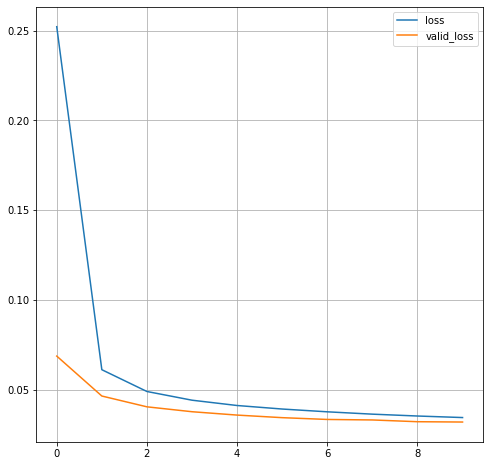

In [46]:
pd.DataFrame({'loss':history.history['loss'],
              'valid_loss':history.history['val_loss'],
              }).plot(figsize=(8, 8))
plt.grid(True)

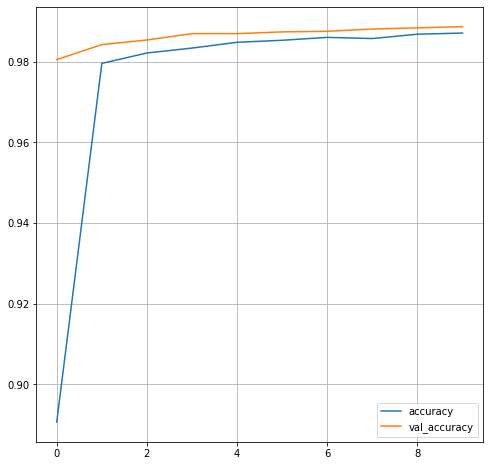

In [47]:
pd.DataFrame({'accuracy':history.history['accuracy'],
              'val_accuracy':history.history['val_accuracy']
              }).plot(figsize=(8, 8))
plt.grid(True)

In [0]:
model.save("densenet.h5")

#Fine tune

In [0]:
densenet.trainable = True

In [50]:
len(densenet.layers)

595

In [0]:
fine_tune_at = 550
for layer in densenet.layers[:fine_tune_at]:
  layer.trainable =  False

In [52]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=0.00001),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 5, 5, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1664)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1665      
Total params: 12,644,545
Trainable params: 1,438,273
Non-trainable params: 11,206,272
_________________________________________________________________


In [53]:
total_epochs =  20

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=valid_batches)

Epoch 10/20
437/437 [==============================] - 74s 169ms/step - loss: 0.0512 - accuracy: 0.9827 - val_loss: 0.0346 - val_accuracy: 0.9884
Epoch 11/20
437/437 [==============================] - 70s 161ms/step - loss: 0.0430 - accuracy: 0.9839 - val_loss: 0.0317 - val_accuracy: 0.9895
Epoch 12/20
437/437 [==============================] - 70s 160ms/step - loss: 0.0406 - accuracy: 0.9842 - val_loss: 0.0303 - val_accuracy: 0.9903
Epoch 13/20
437/437 [==============================] - 69s 158ms/step - loss: 0.0342 - accuracy: 0.9882 - val_loss: 0.0292 - val_accuracy: 0.9904
Epoch 14/20
437/437 [==============================] - 71s 162ms/step - loss: 0.0321 - accuracy: 0.9872 - val_loss: 0.0287 - val_accuracy: 0.9911
Epoch 15/20
437/437 [==============================] - 71s 163ms/step - loss: 0.0283 - accuracy: 0.9898 - val_loss: 0.0282 - val_accuracy: 0.9910
Epoch 16/20
437/437 [==============================] - 71s 162ms/step - loss: 0.0280 - accuracy: 0.9893 - val_loss: 0.0279 -

In [54]:
model.evaluate(test_batches)

73/73 [==============================] - 6s 81ms/step - loss: 0.0353 - accuracy: 0.9867


[0.03533817455172539, 0.9866724014282227]

In [0]:
model.save("densenet_finetuned_45.h5")

In [0]:
# files.download("densenet_finetuned_45.h5")